In [50]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data Cleaning

In [37]:
# Load
df = pd.read_csv("GP3_Data.csv")

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create "post" variable (policy starts Mar 1)
df["post"] = (df["Date"] >= "2023-03-01").astype(int)

# Region dummies
df_dummy = pd.get_dummies(df["Region"], prefix="R", drop_first=False)
df = pd.concat([df, df_dummy], axis=1)

# Create Unit Discount Applied (Region 3 only)
df["Unit Discount Applied"] = ((df["Discount Applied"] == 1) & (df["Region"] == 3)).astype(int)

# Create Delivery Discount Applied (Region 4 only)
df["Delivery Discount Applied"] = ((df["Discount Applied"] == 1) & (df["Region"] == 4)).astype(int)

Diagnostic codes

In [17]:
# Check if unit price discount implemented since March
df.query("Region == 3").groupby("post")["Unit Price"].mean()

post
0    16.0
1    15.2
Name: Unit Price, dtype: float64

In [18]:
# Check if delivery fee discount applied since March
df.query("Region == 4").groupby("post")["Delivery Fees"].mean()

post
0    7.500
1    7.125
Name: Delivery Fees, dtype: float64

In [19]:
# Check if Discount Applied matches region rules
df.groupby(["Region", "post"])["Discount Applied"].mean()

Region  post
1       0       0.0
        1       0.0
2       0       0.0
        1       0.0
3       0       0.0
        1       1.0
4       0       0.0
        1       1.0
Name: Discount Applied, dtype: float64

# Descriptive Statistics

In [21]:
df.describe()

,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied,post
count,480,480.0000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,2023-03-01 12:00:00,2.5000,15.898333,14.041667,7.750000,3.827344,0.254167,0.508333
min,2023-01-01 00:00:00,1.0000,15.200000,1.000000,2.000000,1.000000,0.000000,0.000000
25%,2023-01-30 18:00:00,1.7500,16.000000,10.000000,4.250000,2.125000,0.000000,0.000000
50%,2023-03-01 12:00:00,2.5000,16.000000,15.000000,7.000000,3.500000,0.000000,1.000000
75%,2023-03-31 06:00:00,3.2500,16.000000,18.000000,10.500000,5.156250,1.000000,1.000000
max,2023-04-30 00:00:00,4.0000,16.000000,24.000000,15.000000,7.500000,1.000000,1.000000
std,NaN,1.1192,0.266731,5.472491,4.872058,2.367201,0.435846,0.500452


In [20]:
# Summary statistics by region
summary_region = df.groupby("Region").agg({
    "Unit Price": "mean",
    "Quantity Ordered": ["mean", "std"],
    "Delivery Fees": "mean",
    "Discount Applied": "mean"
})
print(summary_region)

       Unit Price Quantity Ordered           Delivery Fees Discount Applied
             mean             mean       std          mean             mean
Region                                                                     
1       16.000000        19.458333  1.795867      1.000000         0.000000
2       16.000000        15.850000  1.912585      2.500000         0.000000
3       15.593333        12.550000  4.713382      4.500000         0.508333
4       16.000000         8.308333  4.813838      7.309375         0.508333


In [22]:
# Price before/after Mar 1 by region
price_change = df.groupby(["Region","post"])["Unit Price"].mean()
print(price_change)

# Quantity before/after Mar 1 by region
qty_change = df.groupby(["Region","post"])["Quantity Ordered"].mean()
print(qty_change)

Region  post
1       0       16.0
        1       16.0
2       0       16.0
        1       16.0
3       0       16.0
        1       15.2
4       0       16.0
        1       16.0
Name: Unit Price, dtype: float64
Region  post
1       0       19.762712
        1       19.163934
2       0       16.101695
        1       15.606557
3       0        9.406780
        1       15.590164
4       0        6.644068
        1        9.918033
Name: Quantity Ordered, dtype: float64


In [25]:
daily_demand = df.groupby("Date")["Quantity Ordered"].sum()
print(daily_demand.head())

Date
2023-01-01    50
2023-01-02    50
2023-01-03    64
2023-01-04    54
2023-01-05    62
Name: Quantity Ordered, dtype: int64


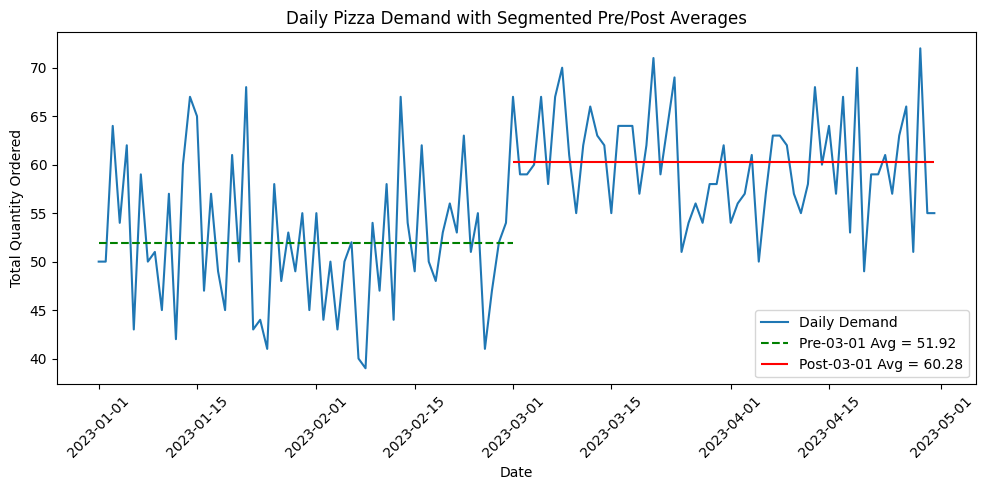

In [36]:
# Daily demand trend
# Define pre / post periods relative to 2023-03-01
# Daily total demand across all regions
daily = df.groupby("Date")["Quantity Ordered"].sum()

# Define cutoff
cutoff = pd.to_datetime("2023-03-01")

# Pre and post averages
pre_avg = daily[daily.index < cutoff].mean()
post_avg = daily[daily.index >= cutoff].mean()

# === Line chart with segmented average lines ===
plt.figure(figsize=(10, 5))

# Main daily demand line
plt.plot(daily.index, daily.values, label="Daily Demand")

# Pre-policy average line: from min date to cutoff
plt.hlines(pre_avg,
           xmin=daily.index.min(),
           xmax=cutoff,
           linestyles="--",
           color = "green",
           label=f"Pre-03-01 Avg = {pre_avg:.2f}")

# Post-policy average line: from cutoff to max date
plt.hlines(post_avg,
           xmin=cutoff,
           xmax=daily.index.max(),
           color = "red",
           linestyles="-",
           label=f"Post-03-01 Avg = {post_avg:.2f}")

plt.title("Daily Pizza Demand with Segmented Pre/Post Averages")
plt.xlabel("Date")
plt.ylabel("Total Quantity Ordered")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

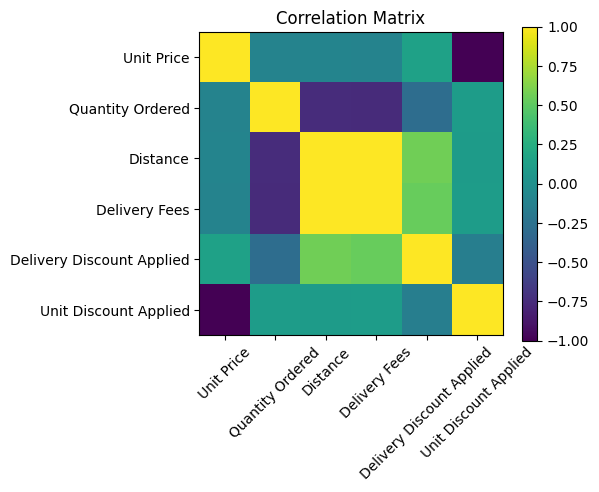

In [38]:
# Correlation Matrix
corr = df[["Unit Price",
           "Quantity Ordered",
           "Distance",
           "Delivery Fees",
           "Delivery Discount Applied",
           "Unit Discount Applied"]].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation="nearest")  # default colormap
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Modelling & Analysis

# Baseline: OLS

In [54]:
# OLS for demand analysis
y = df["Quantity Ordered"]
X = pd.concat([
    df[["Unit Price", "Delivery Fees"]],
    df_dummy
], axis=1)

X = sm.add_constant(X)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.astype(float)

model_OLS = sm.OLS(y, X).fit()
print(model_OLS.summary())


                            OLS Regression Results                            
Dep. Variable:       Quantity Ordered   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     191.4
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          2.92e-111
Time:                        11:26:13   Log-Likelihood:                -1231.3
No. Observations:                 480   AIC:                             2475.
Df Residuals:                     474   BIC:                             2500.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           136.2708     10.334     13.187

In [55]:
# Fixed_Effect Model: Removing all time / date fixed efsects

date_dummies = pd.get_dummies(df["Date"], prefix="D", drop_first=True)

X = pd.concat([
    df[["Unit Price", "Delivery Fees"]],
    df_dummy, # Region dummies
    date_dummies
], axis=1)

X = sm.add_constant(X)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.astype(float)

model_DateFE = sm.OLS(y, X).fit()
print(model_DateFE.summary())

                            OLS Regression Results                            
Dep. Variable:       Quantity Ordered   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     8.842
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           5.37e-59
Time:                        11:28:41   Log-Likelihood:                -1158.5
No. Observations:                 480   AIC:                             2567.
Df Residuals:                     355   BIC:                             3089.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   149.27

# DiD for both price and delivery fee discounts

Parallel trend testing

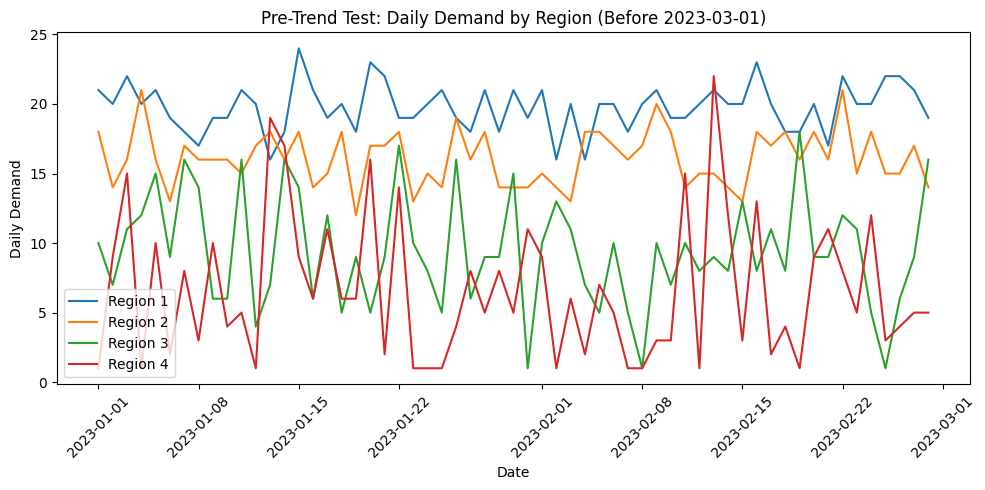

In [56]:
# Parallel Trend Plotting

# Filter pre-treatment period
pre_df = df[df["Date"] < "2023-03-01"]

# Aggregate daily demand by region
pre_daily = pre_df.groupby(["Date", "Region"])["Quantity Ordered"].sum().reset_index()

# Reshape for plotting
pivot = pre_daily.pivot(index="Date", columns="Region", values="Quantity Ordered")

# Plot
plt.figure(figsize=(10,5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=f"Region {col}")

plt.xlabel("Date")
plt.ylabel("Daily Demand")
plt.title("Pre-Trend Test: Daily Demand by Region (Before 2023-03-01)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


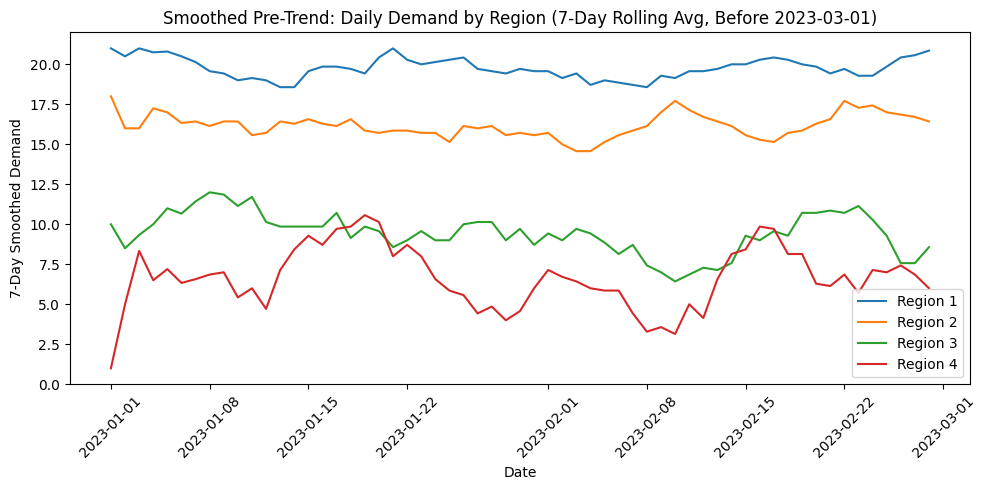

In [57]:
# Seems messy, needs a smoother version
# Aggregate daily demand every 7 days

# Aggregate daily demand by region
pre_daily = pre_df.groupby(["Date", "Region"])["Quantity Ordered"].sum().reset_index()

# Apply 7-day rolling average smoothing (within each region)
pre_daily["Smooth"] = pre_daily.groupby("Region")["Quantity Ordered"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)

# Pivot for plotting
pivot_smooth = pre_daily.pivot(index="Date", columns="Region", values="Smooth")

# Plot
plt.figure(figsize=(10,5))
for col in pivot_smooth.columns:
    plt.plot(pivot_smooth.index, pivot_smooth[col], label=f"Region {col}")

plt.xlabel("Date")
plt.ylabel("7-Day Smoothed Demand")
plt.title("Smoothed Pre-Trend: Daily Demand by Region (7-Day Rolling Avg, Before 2023-03-01)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

DiD: 2 separate models for unit price/ delivery fee discount, 1 more model aggregate these 2 effects.

In [58]:
# Data preparation
df["post"] = (df["Date"] >= "2023-03-01").astype(int)

df["D_R3"] = df["R_3"]
df["D_R4"] = df["R_4"]

df["DID_R3"] = df["D_R3"] * df["post"]
df["DID_R4"] = df["D_R4"] * df["post"]

In [60]:
# DiD Model 1: Evaluate Unit Price Discount Effect

df_R3 = df[df["Region"].isin([1,2,3])].copy()

# Use your existing region dummies (drop R_1)
region_FE_R3 = df_R3[["R_2", "R_3"]]

# Date FE
date_FE_R3 = pd.get_dummies(df_R3["Date"], prefix="D", drop_first=True)

X1 = pd.concat([
    df_R3[["DID_R3", "post", "D_R3"]],
    region_FE_R3,
    date_FE_R3
], axis=1)

X1 = sm.add_constant(X1)
X1 = X1.apply(pd.to_numeric, errors='coerce')
X1 = X1.astype(float)
y1 = df_R3["Quantity Ordered"]

model_DID_R3 = sm.OLS(y1, X1).fit()
print(model_DID_R3.summary())


                            OLS Regression Results                            
Dep. Variable:       Quantity Ordered   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     5.896
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           1.43e-31
Time:                        11:50:36   Log-Likelihood:                -775.71
No. Observations:                 360   AIC:                             1797.
Df Residuals:                     237   BIC:                             2275.
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    20.97

In [61]:
# DiD Model 2: Evaluate Delivery Fee Discount Effect

df_R4 = df[df["Region"].isin([1,2,4])].copy()

region_FE_R4 = df_R4[["R_2", "R_4"]]   # drop R_1

date_FE_R4 = pd.get_dummies(df_R4["Date"], prefix="D", drop_first=True)

X2 = pd.concat([
    df_R4[["DID_R4", "post", "D_R4"]],
    region_FE_R4,
    date_FE_R4
], axis=1)

X2 = sm.add_constant(X2)
X2 = X2.apply(pd.to_numeric, errors='coerce')
X2 = X2.astype(float)
y2 = df_R4["Quantity Ordered"]

model_DID_R4 = sm.OLS(y2, X2).fit()
print(model_DID_R4.summary())

                            OLS Regression Results                            
Dep. Variable:       Quantity Ordered   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     8.277
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           2.57e-43
Time:                        11:53:56   Log-Likelihood:                -833.06
No. Observations:                 360   AIC:                             1912.
Df Residuals:                     237   BIC:                             2390.
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    18.90

In [62]:
# DiD Model 3: Evaluate Both Discount Effects Simultaneously
# We also would like to see if they have any influence on each other

region_FE_all = df[["R_2", "R_3", "R_4"]]   # R_1 omitted

date_FE_all = pd.get_dummies(df["Date"], prefix="D", drop_first=True)

X3 = pd.concat([
    df[["DID_R3", "DID_R4", "post", "D_R3", "D_R4"]],
    region_FE_all,
    date_FE_all
], axis=1)

X3 = sm.add_constant(X3)
X3 = X3.apply(pd.to_numeric, errors='coerce')
X3 = X3.astype(float)
y3 = df["Quantity Ordered"]

model_DID_both = sm.OLS(y3, X3).fit()
print(model_DID_both.summary())

                            OLS Regression Results                            
Dep. Variable:       Quantity Ordered   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     8.842
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           5.37e-59
Time:                        11:53:59   Log-Likelihood:                -1158.5
No. Observations:                 480   AIC:                             2567.
Df Residuals:                     355   BIC:                             3089.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    19.25